In [18]:
import numpy  as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

# Сслабая локализация с помощью скользящего окна

## Создание модели классификации

### Подготовка датасета

In [19]:
# Загрузка датасета
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1).astype(np.float32) / 255
x_test = x_test.reshape(-1, 28, 28, 1).astype(np.float32) / 255

###  Визуализация нескольких образцов из MNIST

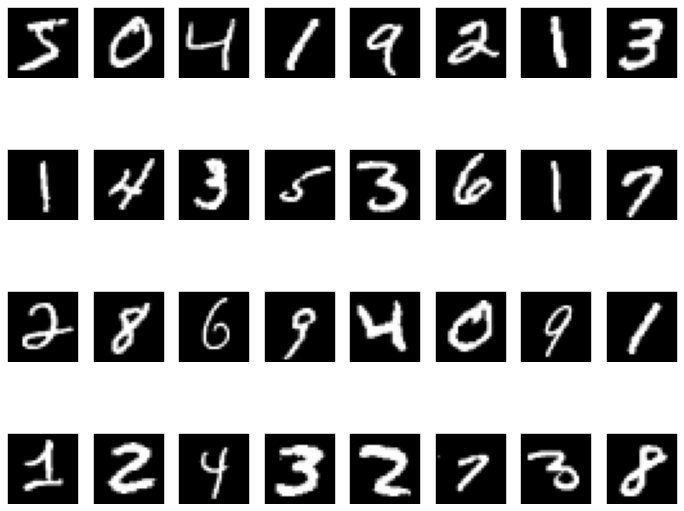

In [20]:
def plot_some_samples(some_samples):
    fig = plt.figure(figsize=(12, 10))
    for some_sample in range(some_samples.shape[0]):
        ax = fig.add_subplot(4, 8, some_sample+1)
        ax.imshow(some_samples[some_sample,:,:,0], cmap="gray")
        plt.xticks([]), plt.yticks([])
    plt.show()

plot_some_samples(x_train[:32])

### Аугментация: добавление образцов класса "фон"

Для задач локализации нам необходимо добавить дополнительный класс "фон", который обозначает "отсутствие цифры". Индекс этого 11-го класса будет "10" (так как классы нумеруются с нуля).

Однако, недостаточно просто взять черную картинку и использовать её как образец "фона". Если в скользящее окно попадает небольшой кусочек цифры, это тоже должно означать "отсутствие цифры".

Сгенерируем соответствующие образцы из образцов MNIST со случайным смещением по координатам X и Y в диапазоне [25%, 75%].

Так как при таком подходе у нас будут автоматически получаться абсолютно чёрные картинки (где цифра после сдвига ушла за пределы картинки), нам не нужно отдельно генерировать чисто чёрные картинки для класса "фон".

Затем визуализируем несколько образцов.

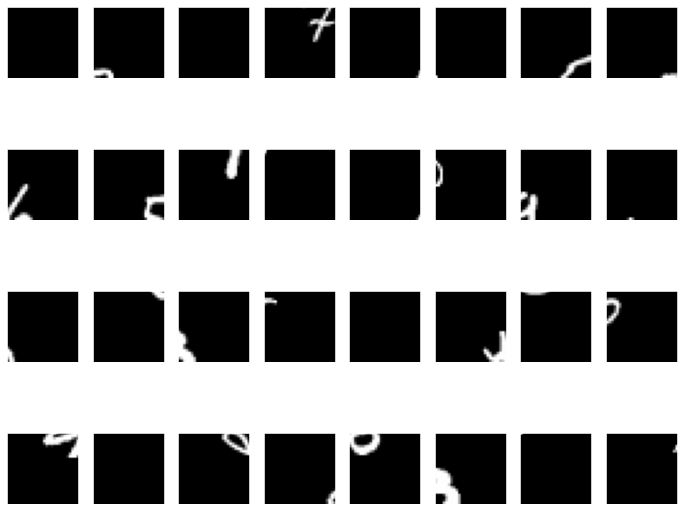

In [21]:
bg_samples = 100000 # Количество обучающих образцов из класса "фон"

x_train_bg = np.zeros((bg_samples, 28, 28, 1), dtype=np.float32)
y_train_bg = np.ones((bg_samples,), dtype=np.int32)*10

src_idxs = random.choices(range(x_train.shape[0]), k=bg_samples)

sh = x_train.shape[1]
sw = x_train.shape[2]
for i in range(bg_samples):
    dh = random.randint(sh//4, 3*sh//4) * random.choice([-1, 1])
    dw = random.randint(sw//4, 3*sw//4) * random.choice([-1, 1])

    sample = x_train[src_idxs[i], ...]

    x_train_bg[i, max(-dh,0):min(sh-dh,sh), max(-dw,0):min(sw-dw, sw), :] = \
        sample[max( dh,0):min(sh+dh,sh), max( dw,0):min(sw+dw, sw), :]

plot_some_samples(x_train_bg[:32, ...])

### Аугментация: добавление образцов исходных классов цифр

Для более наглядной локализации необходимо также добавить образцы с незначительными смещениями. Если цифра не строго по центру, но всё равно попала в окно, значит это окно надо классифицировать как цифру.

Сгенерируем соответствующие образцы из образцов MNIST со случайным смещением по координатам X и Y в диапазоне [0, 25%].

Затем визуализируем несколько образцов.

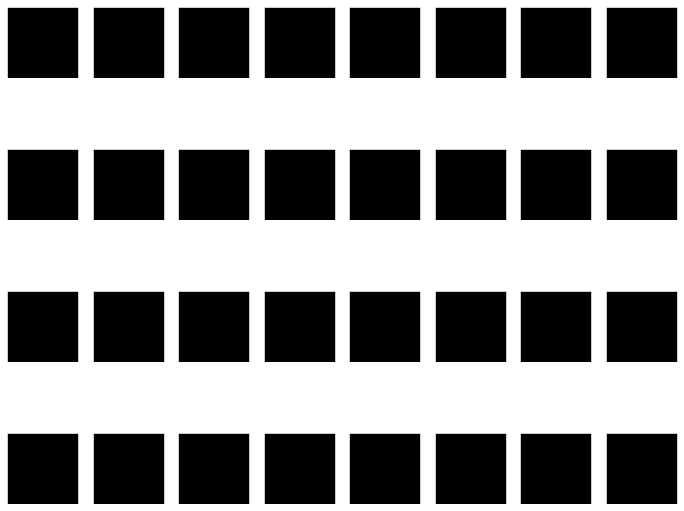

In [22]:
sh_samples = 50000 # Количество дополнительно сгенерированных образов для цифр (со смещениями)

x_train_sh = np.zeros((sh_samples, 28, 28, 1), dtype=np.float32)
y_train_sh = np.zeros((sh_samples,), dtype=np.int32)

src_idxs = random.sample(range(x_train.shape[0]), sh_samples)

sh = x_train.shape[1]
sw = x_train.shape[2]
for i in range(sh_samples):
    dh = random.randint(0, sh//4) * random.choice([-1, 1])
    dw = random.randint(0, sw//4) * random.choice([-1, 1])

    sample = x_train[src_idxs[i], ...]

    x_train_sh[i, max(-dh,0):min(sh-dh,sh), max(-dw,0):min(sw-dw, sw), :] = \
        sample[max( dh,0):min(sh+dh,sh), max( dw,0):min(sw+dw, sw), :]
    x_train_sh[i] = y_train[src_idxs[i]]

plot_some_samples(x_train_sh[:32, ...])

### Объединение исходного датасета MNSIT и двух новых сгенерированных

In [23]:
x_train = np.concatenate((x_train, x_train_bg, x_train_sh), axis=0)
y_train = np.concatenate((y_train, y_train_bg, y_train_sh), axis=0)

### Обучение классификатора

Для начала нам необходимо обучить обычный классификатор для распознавания цифр, но на нашем новом аугментированном датасете с классом "фон".
Далее мы будем применять этот классификатор для задачи слабой локализации.

In [24]:
NUM_CLASSES = 11
NUM_EPOCHS = 3
BATCH_SIZE = 64

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
])

loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [25]:
model.fit(x_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/3
3282/3282 [==============================] - 206s 63ms/step - loss: 0.0979 - accuracy: 0.9642
Epoch 2/3
3282/3282 [==============================] - 210s 64ms/step - loss: 0.0644 - accuracy: 0.9729
Epoch 3/3
3282/3282 [==============================] - 211s 64ms/step - loss: 0.0600 - accuracy: 0.9741


In [26]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 0.0337 - accuracy: 0.9888


[0.03373135253787041, 0.9887999892234802]

## Слабая локализация с помощью скользящего окна
Теперь у нас есть обученный классификатор, который мы можем применить для решения задачи слабой локализации.

Для начала сгенерируем тестовое изображение для задачи локализации, а затем применим для него подход скользящего окна (построим тепловые карты).

Чтобы построить тепловые карты, нам необходимо применить классификатор для различных участков входного изображения (в режиме скользящего окна) и записать ответ (распределение вероятностей) в соответствующий пиксель тензора тепловых карт

### Получение входного изображения для локализации



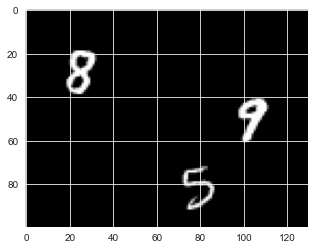

In [62]:
if True: # Сгенерировать случайное изображение

    img = np.zeros((100, 130, 1), dtype=np.float32)
    def add_digit(img, digit):
        ofs = (random.randint(0, img.shape[0]-digit.shape[0]),
               random.randint(0, img.shape[1]-digit.shape[1]))
        img[ofs[0]:ofs[0]+digit.shape[0], ofs[1]:ofs[1]+digit.shape[1], :] += digit
        img = np.clip(img, 0.0, 1.0)
        return img
    for _ in range(3):
        digit = x_test[random.randint(0, x_test.shape[0])]
        img = add_digit(img, digit)

else: # Загрузить готовое изображение 'digits.png'

    INPUT_IMAGE_FPTAH = 'img/digits.png'
    img = imageio.imread(INPUT_IMAGE_FPTAH, pilmode="RGB")
    img = img.astype(np.float32)/255.
    img = np.mean(img, axis=2, keepdims=True)

# Превращение входной картинки в RGB
# (для визуализации и последующего смешивания с цветной тепловой картой)
img_clr = np.tile(img, (1, 1, 3))
_=plt.imshow(img_clr)

### Подготовка буфера для тепловых карт

Буфер тепловых карт будет являться трёхмерным тензором. Первые два измерения - пространственные, третье измерение - ответственно за классы, который у нас 11. Другими словами у нас есть 11 двумерных тепловых карт, ответственных за каждый отдельный класс. Значения в тепловой карте будут в диапазоне [0, 1], что означает вероятность принадлежности данного пикселя к тому или иному классу. Эти вероятности мы будем брать из выхода классификатора.

Пространственные размерности тепловых карт будут меньше, чем входное изображение. Они будут соответствовать тому, сколько раз можно "уложить" скользящее окно во входном изображении (от края до края).

In [63]:
inp_shape = (x_train.shape[1], x_train.shape[2]) # размер входа для классификатора

heatmaps = np.zeros((
    img.shape[0] - inp_shape[0] + 1,
    img.shape[1] - inp_shape[1] + 1,
    NUM_CLASSES))

### Пример применения классификатора
В этом примере кода мы берем кусочек входной картинки (размером 28x28) из левого верхнего угла, подаём его в классификатор, получем вектор распределения вероятностей и записываем этот вектор в соответствующую позицию в тепловых картах

Кроме того, здесь используется магическая функция %%time, которая замеряет время работы данной ячейки

In [64]:
%%time

window = img[0:inp_shape[0], 0:inp_shape[1], :]
pred = model.predict(window[None, ...])[0, ...]
heatmaps[0, 0, :] = pred

1/1 [==============================] - 0s 29ms/step
CPU times: total: 78.1 ms
Wall time: 72 ms


### Запуск классификатора в режиме скользящего окна

In [ ]:
%%time

for i in range(heatmaps.shape[0]):
    for j in range(heatmaps.shape[1]):
        window = img[i:i+inp_shape[0], j:j+inp_shape[1], :]
        heatmaps[i,j,:] = model.predict(window[None, ...])[0, ...]

1/1 [==============================] - 0s 21ms/step


### Расширение тепловых карт

Далее для наглядности будем накладывать тепловые карты на исходное изображение, чтобы увидеть, где что нашлось. Но так как тепловые карты имеют меньший размер по сравнению со входом, их надо увеличить. Будем расширять карты до размера входной картинки за счёт паддинга

In [ ]:
diff = (img.shape[0]-heatmaps.shape[0],
        img.shape[1]-heatmaps.shape[1],)

heatmaps = np.pad(heatmaps, (
    (diff[0]//2,diff[0]-diff[0]//2),
    (diff[1]//2,diff[1]-diff[1]//2),
    (0, 0)
), 'constant')

### Визуализация тепловых карт для разных классов

Визуализируем тепловые карты, соответствующие разным классам, наложенные на исходное изображение

In [ ]:
for clss in range(11):
    heatmap = heatmaps[..., clss]
    heatmap_clr = plt.get_cmap('jet')(heatmap)[..., :3]
    print('Heatmap for class:', clss)
    plt.imshow(img_clr*0.5 + heatmap_clr*0.5)
    plt.show()

# Локализация с помощью полносверточной нейронной сети(FCN)